# Resource Management in Dask

This tutorial demonstrates several ways of managing larger than memory data and improving code efficiencies.
    
- Partition
    - dask.dataframe
    - dask.dataarray
    - word count example
- Save data onto disk
    - export intermediate data onto disk 
- Schedular
    - Persist / Compute methods
    - Futures as pointers to remote data
    - Delayed
- Excution in background
    - Network communication example
    
----

- Authors: NCI Virtual Research Environment Team
- Keywords: Xarray, Dask, Diagnostics
- Create Date: 2020-May

-------

## 1. Partition 

Dask operates on chunks. Like what we see in examples of dask arrays and dataframes, Dask provides a parallel, larger-than-memory mechanism using blocked algorithms. Simply put: distributed operation on data series, frame, or array.

*  **Parallel**: Uses all of the cores on your computer
*  **Larger-than-memory**:  Lets you work on datasets that are larger than your available memory by breaking up your data into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.
*  **Blocked Algorithms**:  Perform large computations by performing many smaller computations

A Dask DataFrame is composed of many pandas DataFrames. For `dask.dataframe` the chunking happens only along the index.

<img src="http://dask.pydata.org/en/latest/_images/dask-dataframe.svg" width="30%">

Dask arrays coordinate many Numpy arrays, arranged into chunks within a grid. They support a large subset of the Numpy API.

<img src="http://dask.pydata.org/en/latest/_images/dask-array-black-text.svg">

In this notebook, we'll build some understanding by implementing some blocked algorithms from scratch.

### Dask.DataFrame

In [2]:
import dask

df = dask.datasets.timeseries()
df

,id,name,x,y
npartitions=30,,,,
2000-01-01,int64,object,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


In [3]:
df.head()

,id,name,x,y
timestamp,,,,
2000-01-01 00:00:00,995,Tim,-0.694706,-0.293974
2000-01-01 00:00:01,991,Victor,-0.490690,-0.224381
2000-01-01 00:00:02,1016,Bob,0.004601,0.842453
2000-01-01 00:00:03,1017,Bob,-0.213497,0.147486
2000-01-01 00:00:04,986,Alice,-0.193732,-0.223112


In [4]:
df["z"] = df.x + df.y
df

,id,name,x,y,z
npartitions=30,,,,,
2000-01-01,int64,object,float64,float64,float64
2000-01-02,...,...,...,...,...
...,...,...,...,...,...
2000-01-30,...,...,...,...,...
2000-01-31,...,...,...,...,...


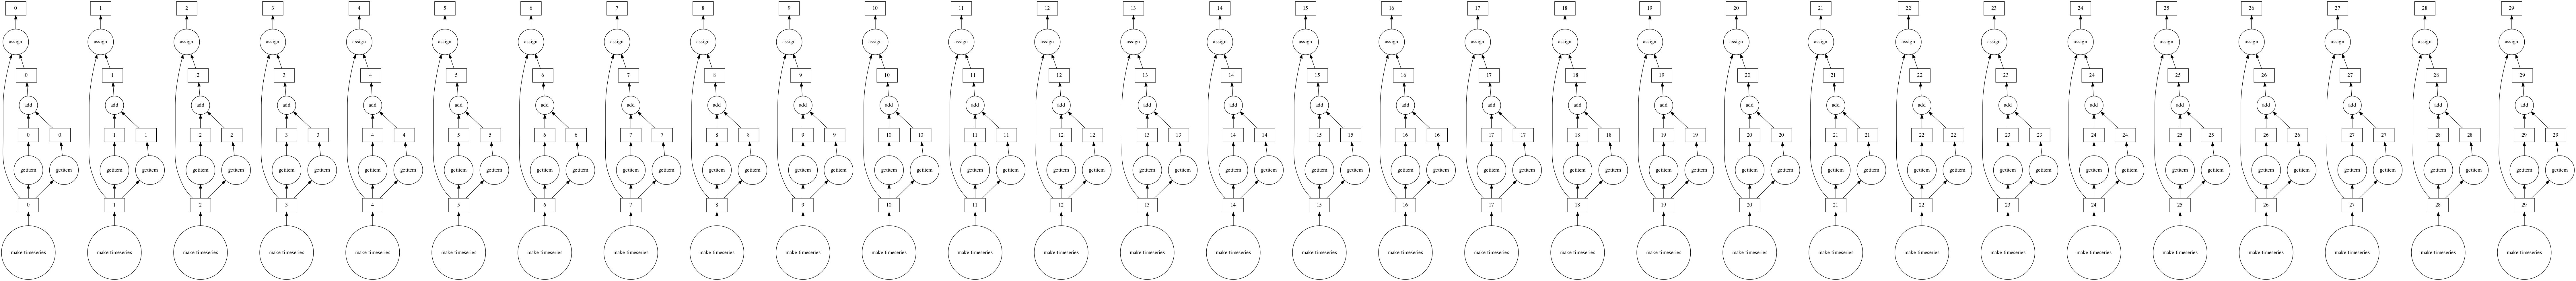

In [5]:
df.visualize()

In [ ]:
import h5py
from glob import glob
import os
import dask.array as da

filenames = sorted(glob(os.path.join('data', 'weather-big', '*.hdf5')))
dsets = [h5py.File(filename, mode='r')['/t2m'] for filename in filenames]

arrays = [da.from_array(dset, chunks=(500, 500)) for dset in dsets]

x = da.stack(arrays, axis=0)

result = x[:, ::2, ::2]

da.to_zarr(result, os.path.join('data', 'myfile.zarr'), overwrite=True)

### Dask.dataarray

In [ ]:
path = '/g/data/oi10/replicas/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp585/r1i1p1f1/day/pr/gr1/v20180701/*'
f_ssp585 = xr.open_mfdataset(path)
# Use Dask.Distributed utility function to display size of each dataset
from distributed.utils import format_bytes

print(
    "ssp585:",
    format_bytes(f_ssp585.nbytes),
)
dsets = xr.open_mfdataset(path,chunks={'time':730})
#Make a list of dask.array objects out of your list of h5py.Dataset objects using the da.from_array function with a chunk size of (500, 500).
arrays = [da.from_array(dset, chunks=(500, 500)) for dset in dsets]
#Stack this list of dask.array objects into a single dask.array object with da.stack
#Stack these along the first axis so that the shape of the resulting array is (31, 5760, 11520).
x = da.stack(arrays, axis=0)

### Simple word out

This directory contains a file called `CdoCompressionExample.sh`. How would you count the number of words in that file?
The simplest approach would be to load all the data into memory, split on whitespace and count the number of results. Here we use a regular expression to split words.

In [ ]:
import re
splitter = re.compile('\w+')
with open('CdoCompressionExample.sh', 'r') as f:
    data = f.read()
result = len(splitter.findall(data))
result

The trouble with this approach is that it does not scale - if the file is very large, it, and the generated list of words, might fill up memory. We can easily avoid that, because we only need a simple sum, and each line is totally independent of the others. Now we evaluate each piece of data and immediately free up the space again, so we could perform this on arbitrarily-large files. Note that there is often a trade-off between time-efficiency and memory footprint: the following uses very little memory, but may be slower for files that do not fill a large faction of memory. In general, one would like chunks small enough not to stress memory, but big enough for efficient use of the CPU.

In [ ]:
result = 0
with open('CdoCompressionExample.sh', 'r') as f:
    for line in f:
        result += len(splitter.findall(line))
result

## 2. Save data onto disk

Whenever we operate on our data we read through all of our data so that we don’t fill up RAM. This is very efficient for memory use, but reading through all of the data files every time can be slow.

As you see in the dask dataframes example, we store our data in Parquet, a format that is more efficient for computers to read and write. It is binary file format. Parquet stores nested data structures in a flat columnar format. Compared to a traditional approach where data is stored in row-oriented approach, parquet is more efficient in terms of storage and performance.

The follow codes were copied over from that example to remind you one way of how to save data onto disk.

In [ ]:
# Write data as parquet format
dd.to_parquet('data/ACT_weather.parquet', engine='pyarrow')
!ls data/ACT_weather.parquet
# Extract binary files from disk and do some calcuation with a better performance gain
%%time 
new_df = pd.read_parquet('data/ACT_weather.parquet', engine='pyarrow')
new_df.rainfall.max()

## 3. Schedular

### Persist sends work to the scheduler

In [6]:
df = df.persist()  # send graph to scheduler
df

,id,name,x,y,z
npartitions=30,,,,,
2000-01-01,int64,object,float64,float64,float64
2000-01-02,...,...,...,...,...
...,...,...,...,...,...
2000-01-30,...,...,...,...,...
2000-01-31,...,...,...,...,...


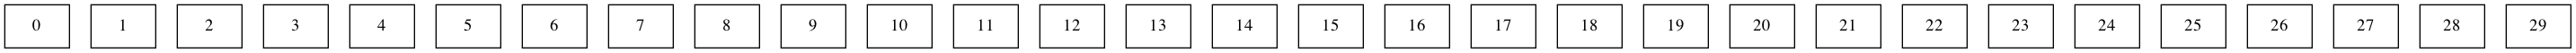

In [7]:
df.visualize()

### Futures Point to Remote Data

In [8]:
from dask.distributed import futures_of

futures_of(df)

[<Future: finished, type: pandas.DataFrame, key: ('assign-e4fd8fc72b4827b087a19bd9cf8b6bd6', 11)>,
 <Future: finished, type: pandas.DataFrame, key: ('assign-e4fd8fc72b4827b087a19bd9cf8b6bd6', 24)>,
 <Future: finished, type: pandas.DataFrame, key: ('assign-e4fd8fc72b4827b087a19bd9cf8b6bd6', 17)>,
 <Future: finished, type: pandas.DataFrame, key: ('assign-e4fd8fc72b4827b087a19bd9cf8b6bd6', 28)>,
 <Future: finished, type: pandas.DataFrame, key: ('assign-e4fd8fc72b4827b087a19bd9cf8b6bd6', 23)>,
 <Future: finished, type: pandas.DataFrame, key: ('assign-e4fd8fc72b4827b087a19bd9cf8b6bd6', 6)>,
 <Future: finished, type: pandas.DataFrame, key: ('assign-e4fd8fc72b4827b087a19bd9cf8b6bd6', 19)>,
 <Future: finished, type: pandas.DataFrame, key: ('assign-e4fd8fc72b4827b087a19bd9cf8b6bd6', 9)>,
 <Future: finished, type: pandas.DataFrame, key: ('assign-e4fd8fc72b4827b087a19bd9cf8b6bd6', 14)>,
 <Future: finished, type: pandas.DataFrame, key: ('assign-e4fd8fc72b4827b087a19bd9cf8b6bd6', 29)>,
 <Future: fi

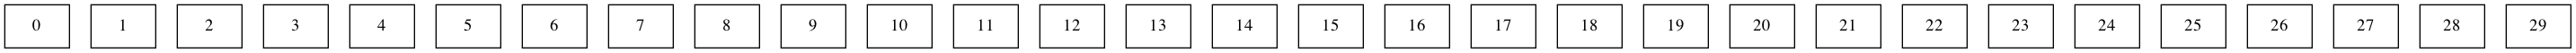

In [9]:
df.visualize()

### Delayed feature provides non-Dask results

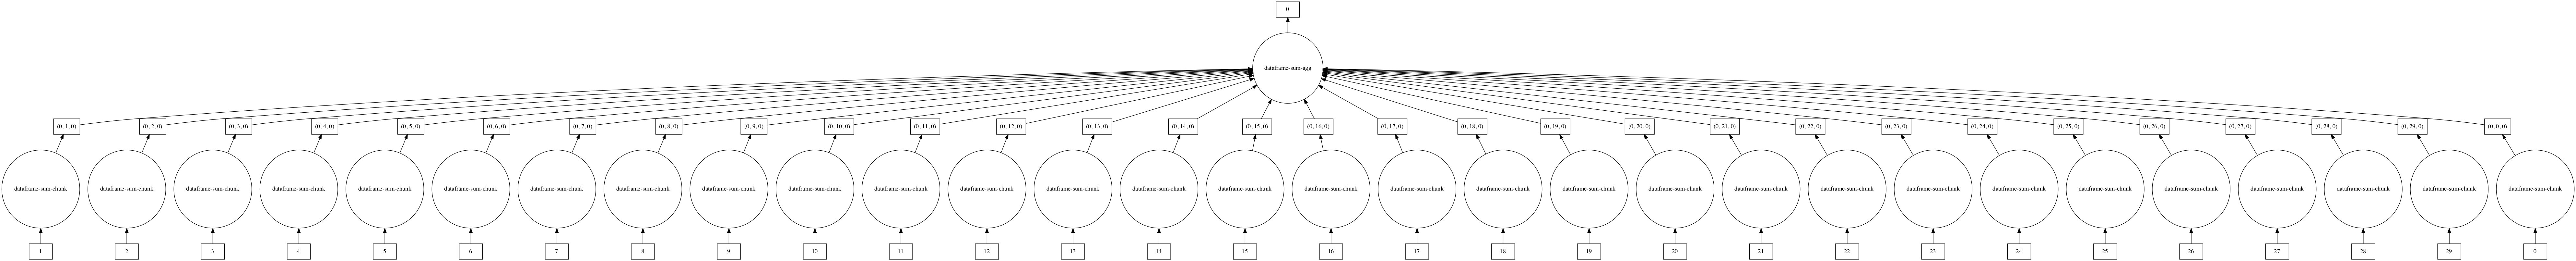

In [10]:
df.sum().visualize()

In [11]:
df.sum().compute()

id                                             2591996411
name    TimVictorBobBobAliceNorbertWendyAliceOliverKev...
x                                                 314.129
y                                                -2208.85
z                                                -1894.73
dtype: object

## 4. Excution in background

There are many tasks that take a while to complete, but don't actually require much of the CPU, for example anything that requires communication over a network, or input from a user. In typical sequential programming, execution would need to halt while the process completes, and then continue execution. That would be dreadful for a user experience (imagine the slow progress bar that locks up the application and cannot be canceled), and wasteful of time (the CPU could have been doing useful work in the meantime.
For example, we can launch processes and get their output as follows:
```python
    import subprocess
    p = subprocess.Popen(command, stdout=subprocess.PIPE)
    p.returncode
```
The task is run in a separate process, and the return-code will remain `None` until it completes, when it will change to `0`. To get the result back, we need `out = p.communicate()[0]` (which would block if the process was not complete).

Similarly, we can launch Python processes and threads in the background. Some methods allow mapping over multiple inputs and gathering the results, more on that later. The thread starts and the cell completes immediately, but the data associated with the download only appears in the queue object some time later.

In [ ]:
import threading
import queue
import urllib

def get_webdata(url, q):
    u = urllib.request.urlopen(url)
    # raise ValueError
    q.put(u.read())

q = queue.Queue()
t = threading.Thread(target=get_webdata, args=('http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-0/1pctCO2/day/atmos/day/r1i1p1/latest/pr/pr_day_ACCESS1-0_1pctCO2_r1i1p1_03000101-03241231.nc.html', q))
t.start()

In [ ]:
# fetch result back into this thread. If the worker thread is not done, this would wait.
q.get()

Consider: what would you see if there had been an exception within the `get_webdata` function? You could uncomment the `raise` line, above, and re-execute the two cells. What happens? Is there any way to debug the execution to find the lYou may need

### Summary

This example summarizes some basic concepts of chunks, dask lazy excution, schedulars, futures and persist utilities and explain how it can help with a better performance.

Reference
https://docs.dask.org/